**Reference**

[A Gentle Introduction to Handling a Non-Stationary Time Series in Python](https://www.analyticsvidhya.com/blog/2018/09/non-stationary-time-series-python/)

[Analyzing Multivariate Time-Series using ARIMAX in Python with StatsModels](https://barnesanalytics.com/analyzing-multivariate-time-series-using-arimax-in-python-with-statsmodels)

In [1]:
import pandas as pd11
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('/Users/ewenwang/Documents/practice_data/salesdata2.csv')
df.head()

,Month,Marketing,Sales
0,1,107.284347,123.819229
1,2,214.523447,267.318463
2,3,327.159934,482.107206
3,4,437.384597,762.756909
4,5,518.389038,997.734857


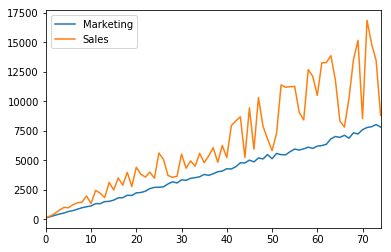

In [42]:
df[['Marketing','Sales']].plot()

## stationary

A stationary series is one in which the properties – mean, variance and covariance, do not vary with time.

Although its very clear that we have a trend (varying mean) in the above series, this visual approach might not always give accurate results. It is better to confirm the observations using some statistical tests.

### ADF (Augmented Dickey Fuller) Test

The Dickey Fuller test is one of the most popular statistical tests. It can be used to determine the presence of unit root in the series, and hence help us understand if the series is stationary or not. The null and alternate hypothesis of this test are:

**Null Hypothesis:** The series has a unit root (value of a =1)

**Alternate Hypothesis:** The series has no unit root.

If we fail to reject the null hypothesis, we can say that the series is non-stationary. This means that the series can be linear or difference stationary.

In [8]:
#define function for ADF test
from statsmodels.tsa.stattools import adfuller

def adf_test(timeseries):
    #Perform Dickey-Fuller test:
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)

In [9]:
adf_test(df['Marketing'])

Results of Dickey-Fuller Test:
Test Statistic                  0.119736
p-value                         0.967383
#Lags Used                      1.000000
Number of Observations Used    73.000000
Critical Value (1%)            -3.523284
Critical Value (5%)            -2.902031
Critical Value (10%)           -2.588371
dtype: float64


In [10]:
adf_test(df['Sales'])

Results of Dickey-Fuller Test:
Test Statistic                 -0.351509
p-value                         0.917886
#Lags Used                     11.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


**Test for stationarity**

If the test statistic is less than the critical value, we can reject the null hypothesis (aka the series is stationary). When the test statistic is greater than the critical value, we fail to reject the null hypothesis (which means the series is not stationary).

In our above example, the test statistic > critical value, which implies that the series is not stationary. This confirms our original observation which we initially saw in the visual test.

### KPSS (Kwiatkowski-Phillips-Schmidt-Shin) Test

KPSS is another test for checking the stationarity of a time series (slightly less popular than the Dickey Fuller test). The null and alternate hypothesis for the KPSS test are opposite that of the ADF test, which often creates confusion.

The authors of the KPSS test have defined the null hypothesis as the process is trend stationary, to an alternate hypothesis of a unit root series. We will understand the trend stationarity in detail in the next section. For now, let’s focus on the implementation and see the results of the KPSS test.

**Null Hypothesis:** The process is trend stationary.

**Alternate Hypothesis:** The series has a unit root (series is not stationary).

In [11]:
#define function for kpss test
from statsmodels.tsa.stattools import kpss

#define KPSS
def kpss_test(timeseries):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression='c')
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)

In [12]:
kpss_test(df['Marketing'])

Results of KPSS Test:
Test Statistic            0.698046
p-value                   0.013723
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


In [13]:
kpss_test(df['Sales'])

Results of KPSS Test:
Test Statistic            0.680570
p-value                   0.015312
Lags Used                12.000000
Critical Value (10%)      0.347000
Critical Value (5%)       0.463000
Critical Value (2.5%)     0.574000
Critical Value (1%)       0.739000
dtype: float64


**Test for stationarity** 

If the test statistic is greater than the critical value, we reject the null hypothesis (series is not stationary). If the test statistic is less than the critical value, if fail to reject the null hypothesis (series is stationary). For the data above, the value of the test statistic is greater than the critical value at 1% confidence intervals, and hence we can say that the series is not stationary.

I usually perform both the statistical tests before I prepare a model for my time series data. It once happened that both the tests showed contradictory results. One of the tests showed that the series is stationary while the other showed that the series is not! I got stuck at this part for hours, trying to figure out how is this possible. As it turns out, there are more than one type of stationarity.

So in summary, the ADF test has an alternate hypothesis of **linear or difference stationary**, while the KPSS test identifies **trend-stationarity** in a series.

## Types of Stationarity

Let us understand the different types of stationarities and how to interpret the results of the above tests.

- Strict Stationary: A strict stationary series satisfies the mathematical definition of a stationary process. For a strict stationary series, the mean, variance and covariance are not the function of time. The aim is to convert a non-stationary series into a strict stationary series for making predictions.
- Trend Stationary: A series that has no unit root but exhibits a trend is referred to as a trend stationary series. Once the trend is removed, the resulting series will be strict stationary. The KPSS test classifies a series as stationary on the absence of unit root. This means that the series can be strict stationary or trend stationary.
- Difference Stationary: A time series that can be made strict stationary by differencing falls under difference stationary. ADF test is also known as a difference stationarity test.

It’s always better to apply both the tests, so that we are sure that the series is truly stationary. Let us look at the possible outcomes of applying these stationary tests.

- Case 1: Both tests conclude that the series is not stationary -> series is not stationary
- Case 2: Both tests conclude that the series is stationary -> series is stationary
- Case 3: KPSS = stationary and ADF = not stationary  -> trend stationary, remove the trend to make series strict stationary
- Case 4: KPSS = not stationary and ADF = stationary -> difference stationary, use differencing to make series stationary

## Making a Time Series Stationary

Now that we are familiar with the concept of stationarity and its different types, we can finally move on to actually making our series stationary. Always keep in mind that in order to use time series forecasting models, it is necessary to convert any non-stationary series to a stationary series first.

 

### Differencing

In this method, we compute the difference of consecutive terms in the series. Differencing is typically performed to get rid of the varying mean. Mathematically, differencing can be written as:

$$y_{(t)} = y_{(t)} – y_{(t-1)}$$

where $y_{(t)}$ is the value at a time t.

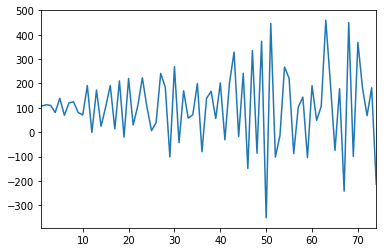

In [43]:
df['Marketing_diff'] = df['Marketing'] - df['Marketing'].shift(1)
df['Marketing_diff'].dropna().plot()

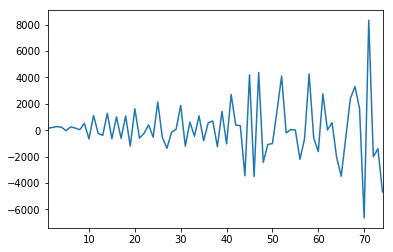

In [44]:
df['Sales_diff'] = df['Sales'] - df['Sales'].shift(1)
df['Sales_diff'].dropna().plot()

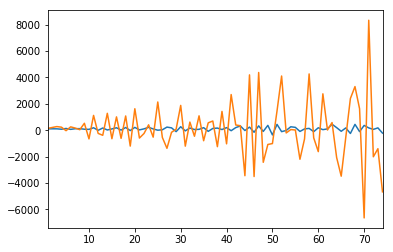

In [45]:
df['Marketing_diff'].dropna().plot()
df['Sales_diff'].dropna().plot()

### Seasonal Differencing

In seasonal differencing, instead of calculating the difference between consecutive values, we calculate the difference between an observation and a previous observation from the same season. For example, an observation taken on a Monday will be subtracted from an observation taken on the previous Monday. Mathematically it can be written as:

$$y_{(t)} = y_{(t)} – y_{(t-7)}$$

### Transformation

Transformations are used to stabilize the non-constant variance of a series. Common transformation methods include power transform, square root, and log transform. Let’s do a quick log transform and differencing on our marketing dataset:

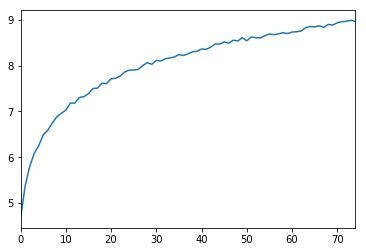

In [18]:
import numpy as np

df['Marketing_log'] = np.log(df['Marketing'])
df['Marketing_log'].plot()

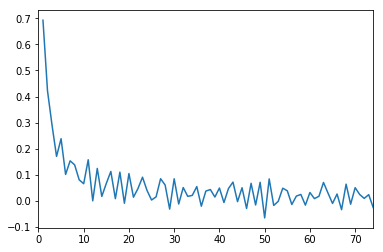

In [19]:
df['Marketing_log_diff'] = df['Marketing_log'] - df['Marketing_log'].shift(1)
df['Marketing_log_diff'].plot()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


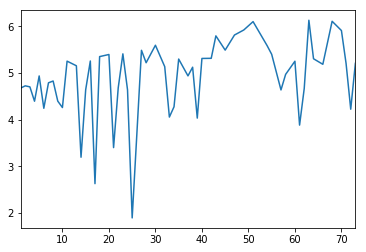

In [21]:
df['Marketing_diff_log'] = np.log(df['Marketing_diff'])
df['Marketing_diff_log'].dropna().plot()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in sqrt
  """Entry point for launching an IPython kernel.


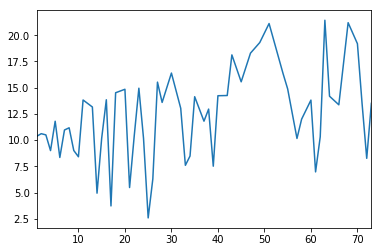

In [22]:
df['Marketing_diff_sqrt'] = np.sqrt(df['Marketing_diff'])
df['Marketing_diff_sqrt'].dropna().plot()

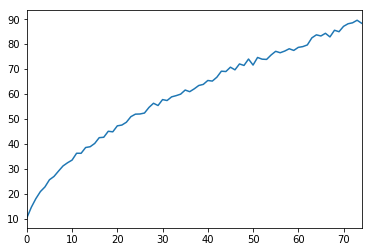

In [23]:
df['Marketing_sqrt'] = np.sqrt(df['Marketing'])
df['Marketing_sqrt'].dropna().plot()

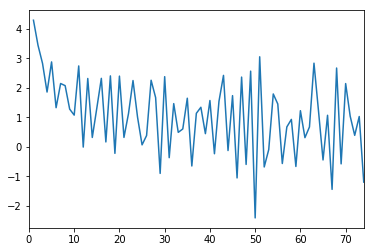

In [24]:
df['Marketing_sqrt_diff'] = df['Marketing_sqrt'] - df['Marketing_sqrt'].shift(1)
df['Marketing_sqrt_diff'].plot()

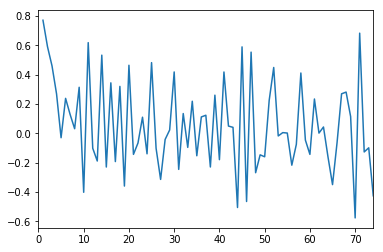

In [25]:
df['Sales_log'] = np.log(df['Sales'])
df['Sales_log_diff'] = df['Sales_log'] - df['Sales_log'].shift(1)
df['Sales_log_diff'].plot()

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in log
  """Entry point for launching an IPython kernel.


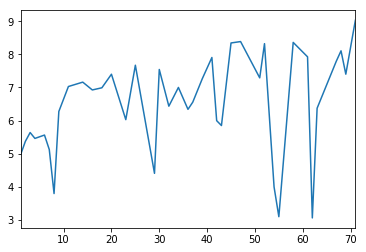

In [27]:
df['Sales_diff_log'] = np.log(df['Sales_diff'])
df['Sales_diff_log'].dropna().plot()

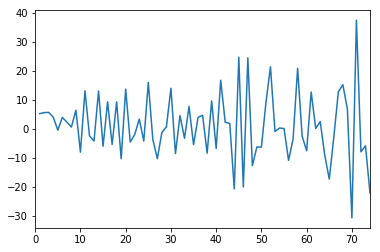

In [28]:
df['Sales_sqrt'] = np.sqrt(df['Sales'])
df['Sales_sqrt_diff'] = df['Sales_sqrt'] - df['Sales_sqrt'].shift(1)
df['Sales_sqrt_diff'].plot()

## ARIMAX

In [30]:
df.head()

,Month,Marketing,Sales,Marketing_diff,Sales_diff,Marketing_log,Marketing_log_diff,Marketing_diff_log,Marketing_diff_sqrt,Marketing_sqrt,Marketing_sqrt_diff,Sales_log,Sales_log_diff,Sales_diff_log,Sales_sqrt,Sales_sqrt_diff,const
0,1,107.284347,123.819229,NaN,NaN,4.675483,NaN,NaN,NaN,10.357816,NaN,4.818823,NaN,NaN,11.127409,NaN,1
1,2,214.523447,267.318463,107.239100,143.499234,5.368419,0.692936,4.675061,10.355631,14.646619,4.288803,5.588441,0.769618,4.966330,16.349877,5.222468,1
2,3,327.159934,482.107206,112.636487,214.788743,5.790449,0.422030,4.724166,10.613034,18.087563,3.440944,6.178167,0.589726,5.369655,21.956940,5.607063,1
3,4,437.384597,762.756909,110.224663,280.649703,6.080813,0.290364,4.702521,10.498793,20.913742,2.826179,6.636939,0.458773,5.637107,27.618054,5.661114,1
4,5,518.389038,997.734857,81.004442,234.977948,6.250726,0.169913,4.394504,9.000247,22.768158,1.854417,6.905488,0.268548,5.459492,31.586941,3.968887,1


In [31]:
df['const']=1

model1 = sm.OLS(endog=df['Sales'], exog=df[['Marketing', 'const']])
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:                  Sales   R-squared:                       0.847
Model:                            OLS   Adj. R-squared:                  0.845
Method:                 Least Squares   F-statistic:                     403.9
Date:                Wed, 12 Jun 2019   Prob (F-statistic):           1.79e-31
Time:                        21:14:42   Log-Likelihood:                -661.83
No. Observations:                  75   AIC:                             1328.
Df Residuals:                      73   BIC:                             1332.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Marketing      1.7029      0.085     20.096      0.0

In [33]:
df['diffS'] = df['Sales'].diff()
df['diffM'] = df['Marketing'].diff()

model2 = sm.OLS(endog=df['diffS'].dropna(), exog=df[['diffM','const']].dropna())
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                  diffS   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.023
Method:                 Least Squares   F-statistic:                     2.708
Date:                Wed, 12 Jun 2019   Prob (F-statistic):              0.104
Time:                        21:18:33   Log-Likelihood:                -671.02
No. Observations:                  74   AIC:                             1346.
Df Residuals:                      72   BIC:                             1351.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffM          2.6104      1.586      1.646      0.1

In [35]:
df['lag'] = df['diffM'].shift()
df.dropna(inplace=True)

model3 = sm.tsa.ARIMA(endog=df['Sales'], exog=df[['lag']], order=[1,1,0])
results3 = model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   30
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -248.799
Method:                       css-mle   S.D. of innovations            960.913
Date:                Wed, 12 Jun 2019   AIC                            505.599
Time:                        21:24:29   BIC                            511.203
Sample:                             1   HQIC                           507.392
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const           183.4853    234.083      0.784      0.440    -275.309     642.279
lag               1.7444      1.111      1.570      0.128      -0.433       3.922
ar.L1.D.Sales    -0.5678      0.160     

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:221: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
